# Birdsong Pytorch Baseline: ResNeSt50-fast (Training)

## Prepare

### import libraries

In [1]:
%%bash
pip install ../input/pytorch-pfn-extras/pytorch-pfn-extras-0.2.1/

Processing /kaggle/input/pytorch-pfn-extras/pytorch-pfn-extras-0.2.1
  Created wheel for pytorch-pfn-extras: filename=pytorch_pfn_extras-0.2.1-py3-none-any.whl size=61392 sha256=7a88371ad65bcd64aae58dfe03a8633f5f83c6d7797d9c9c10977ae71ea9b8cc
  Stored in directory: /root/.cache/pip/wheels/4b/6d/96/1a021d23511ce1a377638f67ba1b0d8d1832fbcd3f0c6c1442
Successfully built pytorch-pfn-extras


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
%%bash
pip install ../input/resnest50-fast-package/resnest-0.0.6b20200701/resnest/

Processing /kaggle/input/resnest50-fast-package/resnest-0.0.6b20200701/resnest
  Created wheel for resnest: filename=resnest-0.0.6b20200909-py3-none-any.whl size=31063 sha256=9acadc2d1c2b22bc9ec5ef77255335432d96027c62f6e70475ad06552c86f199
  Stored in directory: /tmp/pip-ephem-wheel-cache-4k7zvhid/wheels/23/50/5b/3bd292280af53184d3c3f652258ad6173224b2281eef8c4d27
Successfully built resnest


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
pip install pydub

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import re
import gc
import time
import shutil
import random
import warnings
warnings.filterwarnings('ignore')
import typing as tp
from pathlib import Path
from typing import Optional, List
from contextlib import contextmanager

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from pydub import AudioSegment
import albumentations
from albumentations.augmentations import functional as F
from albumentations.core.transforms_interface import DualTransform, BasicTransform

import yaml
from joblib import delayed, Parallel

import cv2
import librosa
import audioread
import soundfile as sf

import numpy as np
import pandas as pd

from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback

from fastprogress import progress_bar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import resnest.torch as resnest_torch

import pytorch_pfn_extras as ppe
from pytorch_pfn_extras.training import extensions as ppe_extensions

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
Path("/root/.cache/torch/checkpoints").mkdir(parents=True)

In [6]:
!cp ../input/resnest50-fast-package/resnest50_fast_*.pth /root/.cache/torch/checkpoints/

### define utilities

In [7]:
import logging

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore


def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger

@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)

set_seed(1213)

### read data

In [8]:
ROOT = Path.cwd().parent
INPUT_ROOT = ROOT / "input"
RAW_DATA = INPUT_ROOT / "birdsong-recognition"
TRAIN_AUDIO_DIR = RAW_DATA / "train_audio"
TRAIN_RESAMPLED_AUDIO_DIRS = [
  INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
]
TEST_AUDIO_DIR = RAW_DATA / "test_audio"

In [9]:
# train = pd.read_csv(RAW_DATA / "train.csv")
train = pd.read_csv(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "train_mod.csv")

if not TEST_AUDIO_DIR.exists():
    TEST_AUDIO_DIR = INPUT_ROOT / "birdcall-check" / "test_audio"
    test = pd.read_csv(INPUT_ROOT / "birdcall-check" / "test.csv")
else:
    test = pd.read_csv(RAW_DATA / "test.csv")

### settings

In [10]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 35
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 50
    shuffle: True
    num_workers: 2
    pin_memory: True
    drop_last: True
  val:
    batch_size: 100
    shuffle: False
    num_workers: 2
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

In [11]:
settings = yaml.safe_load(settings_str)
settings

{'globals': {'seed': 1213,
  'device': 'cuda',
  'num_epochs': 35,
  'output_dir': '/kaggle/training_output/',
  'use_fold': 0,
  'target_sr': 32000},
 'dataset': {'name': 'SpectrogramDataset',
  'params': {'img_size': 224,
   'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}},
 'split': {'name': 'StratifiedKFold',
  'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}},
 'loader': {'train': {'batch_size': 50,
   'shuffle': True,
   'num_workers': 2,
   'pin_memory': True,
   'drop_last': True},
  'val': {'batch_size': 100,
   'shuffle': False,
   'num_workers': 2,
   'pin_memory': True,
   'drop_last': False}},
 'model': {'name': 'resnest50_fast_1s1x64d',
  'params': {'pretrained': True, 'n_classes': 264}},
 'loss': {'name': 'BCEWithLogitsLoss', 'params': {}},
 'optimizer': {'name': 'Adam', 'params': {'lr': 0.001}},
 'scheduler': {'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}}

In [12]:
settings['globals']

{'seed': 1213,
 'device': 'cuda',
 'num_epochs': 35,
 'output_dir': '/kaggle/training_output/',
 'use_fold': 0,
 'target_sr': 32000}

In [13]:
if not torch.cuda.is_available():
    settings["globals"]["device"] = "cpu"

In [14]:
for k, v in settings.items():
    print(f"[{k}]")
    print(f"{v}\n")

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 35, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}

[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}

[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}

[loader]
{'train': {'batch_size': 50, 'shuffle': True, 'num_workers': 2, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 100, 'shuffle': False, 'num_workers': 2, 'pin_memory': True, 'drop_last': False}}

[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}

[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}

[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}

[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}



# Training Data

In [15]:
tmp_list = []
for audio_d in TRAIN_RESAMPLED_AUDIO_DIRS:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [16]:
train_all_list = train_all[["file_path", "ebird_code"]].values.tolist()
print(type(train_all_list))
print(len(train_all_list))
train_all_list[21374]

<class 'list'>
21375


['/kaggle/input/birdsong-resampled-train-audio-04/yetvir/XC55761.wav',
 'yetvir']

In [17]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
######## check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

(264, 5)


In [18]:
######## Use Fold
use_fold = 0
train_file_list = train_all.query("fold != @use_fold")[["file_path", "ebird_code"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "ebird_code"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 0] train: 17100, val: 4275


In [19]:
print(type(train_file_list))
print(len(train_file_list))
print(train_file_list[1425])
print(type(val_file_list))
print(len(val_file_list))
print(val_file_list[1425])

<class 'list'>
17100
['/kaggle/input/birdsong-resampled-train-audio-00/bewwre/XC217823.wav', 'bewwre']
<class 'list'>
4275
['/kaggle/input/birdsong-resampled-train-audio-01/dowwoo/XC142215.wav', 'dowwoo']


In [20]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [21]:
INV_BIRD_CODE[263]

'yetvir'

In [22]:
print(BIRD_CODE["yebsap"])
#print(BIRD_CODE.keys())

259


In [23]:
lab = np.zeros(len(BIRD_CODE), dtype="f")
for ebird in BIRD_CODE:
    lab[BIRD_CODE[ebird]] = 1

lab

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [24]:
lab = np.zeros(len(BIRD_CODE), dtype="f")
lab[BIRD_CODE['y00475']] = 1
lab

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Augmentation

# MelSpectrogram -> Augmentation 

In [25]:
class SpecAugment(data.Dataset):
    def __init__(self, num_mask=2, freq_masking=0.15, time_masking=0.20, always_apply=False, p=0.5):
        
        super(SpecAugment, self).__init__(always_apply, p)
        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking

    
    def apply(self, data, **params):
        melspec, sr = data

        spec_aug = self.drop_stripes(melspec, 
                                     self.num_mask,
                                     self.freq_masking,
                                     self.time_masking,
                                     melspec.min())

        return spec_aug, sr
    
    # Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
    '''Frequency & Time masking'''
    def spec_augment(self, 
                    spec: np.ndarray,
                    num_mask=2,
                    freq_masking=0.15,
                    time_masking=0.20,
                    value=0):
        spec = spec.copy()
        num_mask = random.randint(1, num_mask)
        for i in range(num_mask):
            all_freqs_num, all_frames_num  = spec.shape
            freq_percentage = random.uniform(0.0, freq_masking)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[f0:f0 + num_freqs_to_mask, :] = value

            time_percentage = random.uniform(0.0, time_masking)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[:, t0:t0 + num_frames_to_mask] = value

        return spec


In [26]:
def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.15):
    spec = spec.copy()
    for i in range(num_mask):
        num_freqs, num_frames = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * num_freqs)
        num_frames_to_mask = int(time_percentage * num_frames)
        
        t0 = int(np.random.uniform(low=0.0, high=num_frames - num_frames_to_mask))
        f0 = int(np.random.uniform(low=0.0, high=num_freqs - num_freqs_to_mask))
        
        spec[:, t0:t0 + num_frames_to_mask] = 0      
        spec[f0:f0 + num_freqs_to_mask, :] = 0 
        
    return spec

In [27]:
PERIOD = 5

def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list: tp.List[tp.List[str]], img_size=224,
        waveform_transforms=None, spectrogram_transforms=False, melspectrogram_parameters={}
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = spec_augment(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [28]:
class SpectrogramDataset2(data.Dataset):
    def __init__(self, file_list: tp.List[tp.List[str]], img_size=224,
        waveform_transforms=None, spectrogram_transforms=False, melspectrogram_parameters={}
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            #print(f"Type of melspec: {type(melspec)}")
            melspec = spec_augment(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

        #labels = np.zeros(len(BIRD_CODE), dtype="f")
        #labels[BIRD_CODE[ebird_code]] = 1

        return torch.tensor(image), ebird_code

In [29]:
class SpectrogramDataset3(data.Dataset):
    def __init__(self, file_list: tp.List[tp.List[str]], img_size=224,
        waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            #print(f"Type of melspec: {type(melspec)}")
            melspec = spec_augment(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        for ebird in ebird_code:
            labels[BIRD_CODE[ebird]] = 1
        #labels[BIRD_CODE[ebird_code]] = 1

        return torch.tensor(image), torch.tensor(labels)

In [30]:
print(type(train_file_list))
print(len(train_file_list))
print(train_file_list[1425])
print(type(val_file_list))
print(len(val_file_list))
print(val_file_list[1425])

a,b = train_file_list[0]

print(a)
print(b)

<class 'list'>
17100
['/kaggle/input/birdsong-resampled-train-audio-00/bewwre/XC217823.wav', 'bewwre']
<class 'list'>
4275
['/kaggle/input/birdsong-resampled-train-audio-01/dowwoo/XC142215.wav', 'dowwoo']
/kaggle/input/birdsong-resampled-train-audio-00/aldfly/XC134874.wav
aldfly


In [31]:
def plot_imgs(dataset_show):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    #for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(label)

In [32]:
#tensor_image = dataset_show.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])
#dataset_show.Size()

In [33]:
#im, l = dataset_show[0]
### to get BIRD CODE
#ecode_torch = np.nonzero(l) # Index of Bird Code in Torch Tensor
#ecode_list = ecode_torch.tolist()
#ecode_bird = INV_BIRD_CODE[ecode_list[0][0]]

#fig, axs = plt.subplots()
#axs.set_title(ecode_bird)
#axs.imshow(im.transpose(0, 1).transpose(1,2).squeeze(), aspect= 'auto')


In [34]:
#ind = train_all_list.index("amekes")
train_all_list[455:460]

[['/kaggle/input/birdsong-resampled-train-audio-00/amekes/XC59480.wav',
  'amekes'],
 ['/kaggle/input/birdsong-resampled-train-audio-00/amekes/XC61168.wav',
  'amekes'],
 ['/kaggle/input/birdsong-resampled-train-audio-00/amepip/XC111040.wav',
  'amepip'],
 ['/kaggle/input/birdsong-resampled-train-audio-00/amepip/XC111041.wav',
  'amepip'],
 ['/kaggle/input/birdsong-resampled-train-audio-00/amepip/XC111042.wav',
  'amepip']]

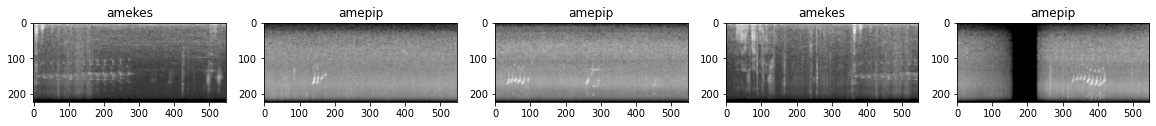

In [35]:
#### Without Augmentation ####
#, melspectrogram_parameters=mel_parameters

mel_parameters = {"n_mels":128, "fmin":20, "fmax":16000}

df_show = train_all_list[455:459]
dataset_show = SpectrogramDataset2(df_show, spectrogram_transforms=False, melspectrogram_parameters=mel_parameters) # len(dataset_show) --> 5
plot_imgs(dataset_show)

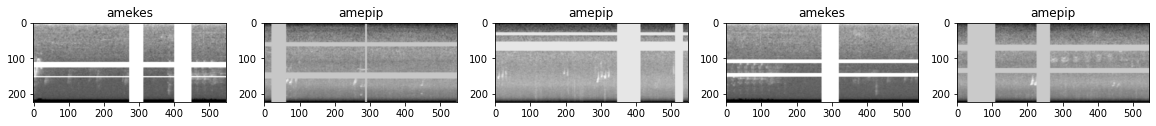

In [36]:
#### With Augmentation ####
#, melspectrogram_parameters=mel_parameters

mel_parameters = {"n_mels":128, "fmin":20, "fmax":16000}

df_show2 = train_all_list[455:460]
dataset_show2 = SpectrogramDataset2(df_show, spectrogram_transforms=True, melspectrogram_parameters=mel_parameters) # len(dataset_show) --> 5
dataset_show2
plot_imgs(dataset_show2)

In [37]:
for i in range(len(dataset_show2)):
    img, label = dataset_show2[i]
    print(len(img)) #--> 3
    print(len(label)) #--> 264
    #print(type(img)) #--> <class 'torch.Tensor'>
    #print(type(label)) #--> <class 'torch.Tensor'>
    #print(np.nonzero(label))
    print(label)
    print("\n---------------------------------------\n")

3
6
amekes

---------------------------------------

3
6
amekes

---------------------------------------

3
6
amepip

---------------------------------------

3
6
amepip

---------------------------------------



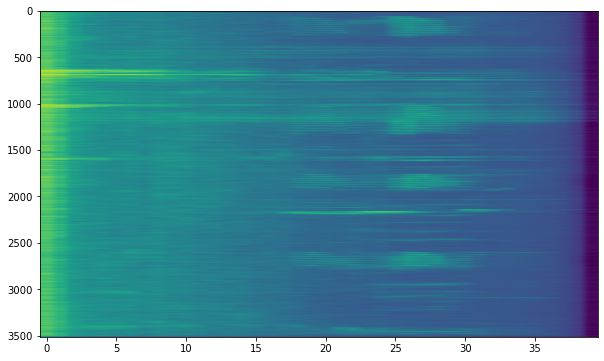

In [38]:
from scipy.io import wavfile
import matplotlib.pyplot as plt

audio_path = os.path.join("/kaggle/input/birdsong-resampled-train-audio-00/amekes/XC59480.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x).astype(np.float32)
#x = librosa.power_to_db(x, ref=np.max)

plt.figure(figsize=(10,6))
plt.imshow(x,aspect= 'auto')
plt.show()

### Training Utility

In [39]:
def get_model(args: tp.Dict):
    model = getattr(resnest_torch, args["name"])(pretrained=args["params"]["pretrained"])
    del model.fc
    # # use the same head as the baseline notebook.
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, args["params"]["n_classes"]))
    
    return model

In [40]:
def train_loop(
    manager, args, model, device,
    train_loader, optimizer, scheduler, loss_func
):
    """Run minibatch training loop"""
    while not manager.stop_trigger:
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            with manager.run_iteration():
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_func(output, target)
                ppe.reporting.report({'train/loss': loss.item()})
                loss.backward()
                optimizer.step()
                scheduler.step()

def eval_for_batch(
    args, model, device,
    data, target, loss_func, eval_func_dict={}
):
    """
    Run evaliation for valid
    
    This function is applied to each batch of val loader.
    """
    model.eval()
    data, target = data.to(device), target.to(device)
    output = model(data)
    # Final result will be average of averages of the same size
    val_loss = loss_func(output, target).item()
    ppe.reporting.report({'val/loss': val_loss})
    
    for eval_name, eval_func in eval_func_dict.items():
        eval_value = eval_func(output, target).item()
        ppe.reporting.report({"val/{}".format(eval_aame): eval_value})

In [41]:
def set_extensions(
    manager, args, model, device, test_loader, optimizer,
    loss_func, eval_func_dict={}
):
    """set extensions for PPE"""
        
    my_extensions = [
        # # observe, report
        ppe_extensions.observe_lr(optimizer=optimizer),
        # ppe_extensions.ParameterStatistics(model, prefix='model'),
        # ppe_extensions.VariableStatisticsPlot(model),
        ppe_extensions.LogReport(),
        ppe_extensions.PlotReport(['train/loss', 'val/loss'], 'epoch', filename='loss.png'),
        ppe_extensions.PlotReport(['lr',], 'epoch', filename='lr.png'),
        ppe_extensions.PrintReport([
            'epoch', 'iteration', 'lr', 'train/loss', 'val/loss', "elapsed_time"]),
#         ppe_extensions.ProgressBar(update_interval=100),

        # # evaluation
        (
            ppe_extensions.Evaluator(
                test_loader, model,
                eval_func=lambda data, target:
                    eval_for_batch(args, model, device, data, target, loss_func, eval_func_dict),
                progress_bar=True),
            (1, "epoch"),
        ),
        # # save model snapshot.
        (
            ppe_extensions.snapshot(
                target=model, filename="snapshot_epoch_{.updater.epoch}.pth"),
            ppe.training.triggers.MinValueTrigger(key="val/loss", trigger=(1, 'epoch'))
        ),
    ]
           
    # # set extensions to manager
    for ext in my_extensions:
        if isinstance(ext, tuple):
            manager.extend(ext[0], trigger=ext[1])
        else:
            manager.extend(ext)
        
    return manager

In [42]:
def get_loaders_for_training(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    train_file_list: tp.List[str], val_file_list: tp.List[str]
):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    #train_dataset = SpectrogramDataset(train_file_list, waveform_transforms = get_train_transforms())
    #val_dataset = SpectrogramDataset(val_file_list, waveform_transforms  =get_train_transforms())
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, val_loader

## run training

In [43]:
# # # get loader
train_loader, val_loader = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)


print(len(train_loader))
print(len(val_loader))

342
43


In [44]:
set_seed(settings["globals"]["seed"])
device = torch.device(settings["globals"]["device"])
output_dir = Path(settings["globals"]["output_dir"])

# # # get model
model = get_model(settings["model"])
model = model.to(device)

# # # get optimizer
optimizer = getattr(
    torch.optim, settings["optimizer"]["name"]
)(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
)(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

# # # create training manager
trigger = None

manager = ppe.training.ExtensionsManager(
    model, optimizer, settings["globals"]["num_epochs"],
    iters_per_epoch=len(train_loader),
    stop_trigger=trigger,
    out_dir=output_dir
)

# # # set manager extensions
manager = set_extensions(
    manager, settings, model, device,
    val_loader, optimizer, loss_func,
)

In [45]:
# # run training 
train_loop(
    manager, settings, model, device,
    train_loader, optimizer, scheduler, loss_func)

epoch       iteration   lr          train/loss  val/loss    elapsed_time
validation [..................................................]  0.00%
         0 iterations
       inf iters/sec. Estimated time to finish: 0:00:00.
validation [#.................................................]  2.33%
         1 iterations
    2.5096 iters/sec. Estimated time to finish: 0:00:16.735406.
validation [##................................................]  4.65%
         2 iterations
   0.46622 iters/sec. Estimated time to finish: 0:01:27.942140.
validation [###...............................................]  6.98%
         3 iterations
   0.58926 iters/sec. Estimated time to finish: 0:01:07.882255.
validation [####..............................................]  9.30%
         4 iterations
   0.42386 iters/sec. Estimated time to finish: 0:01:32.012564.
validation [#####.............................................] 11.63%
         5 iterations
   0.49994 iters/sec. Estimated time to finish: 0:01:16.

In [46]:
del train_loader
del val_loader
del model
del optimizer
del scheduler
del loss_func
del manager

gc.collect()

195628

## save results

In [47]:
%%bash
ls /kaggle/training_output

log
loss.png
lr.png
snapshot_epoch_1.pth
snapshot_epoch_10.pth
snapshot_epoch_12.pth
snapshot_epoch_13.pth
snapshot_epoch_14.pth
snapshot_epoch_15.pth
snapshot_epoch_17.pth
snapshot_epoch_18.pth
snapshot_epoch_19.pth
snapshot_epoch_2.pth
snapshot_epoch_23.pth
snapshot_epoch_24.pth
snapshot_epoch_25.pth
snapshot_epoch_26.pth
snapshot_epoch_27.pth
snapshot_epoch_28.pth
snapshot_epoch_3.pth
snapshot_epoch_35.pth
snapshot_epoch_4.pth
snapshot_epoch_5.pth
snapshot_epoch_6.pth
snapshot_epoch_7.pth
snapshot_epoch_8.pth


In [48]:
for f_name in ["log","loss.png", "lr.png"]:
    shutil.copy(output_dir / f_name, f_name)

In [49]:
log = pd.read_json("log")
best_epoch = log["val/loss"].idxmin() + 1
log.iloc[[best_epoch - 1],]

,train/loss,lr,val/loss,epoch,iteration,elapsed_time
34,0.006649,0.0,0.010288,35,11970,23080.515937


In [50]:
shutil.copy(output_dir / "snapshot_epoch_{}.pth".format(best_epoch), "best_model.pth")

'best_model.pth'

In [51]:
m = get_model({
    'name': settings["model"]["name"],
    'params': {'pretrained': False, 'n_classes': 264}})
state_dict = torch.load('best_model.pth')
m.load_state_dict(state_dict)

<All keys matched successfully>